In [1]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
import matplotlib.pyplot as plt
cm = plt.get_cmap('jet')

def scale(data, a, b):
    return np.clip((data - a)/(b-a), 0., 1.)

# set some a and b values for scaling
scale_clip = {"reflectivity": (-15, 30),
              "velocity": (-15, 15), 
              "spectrum_width": (0, 8)}


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/scratch2/wenlongzhao/anaconda3/envs/roost2021/lib/python3.6/site-packages/pyart/io/nexrad_archive.py:212: UserWarning: Gate spacing is not constant, interpolating data in scans [4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


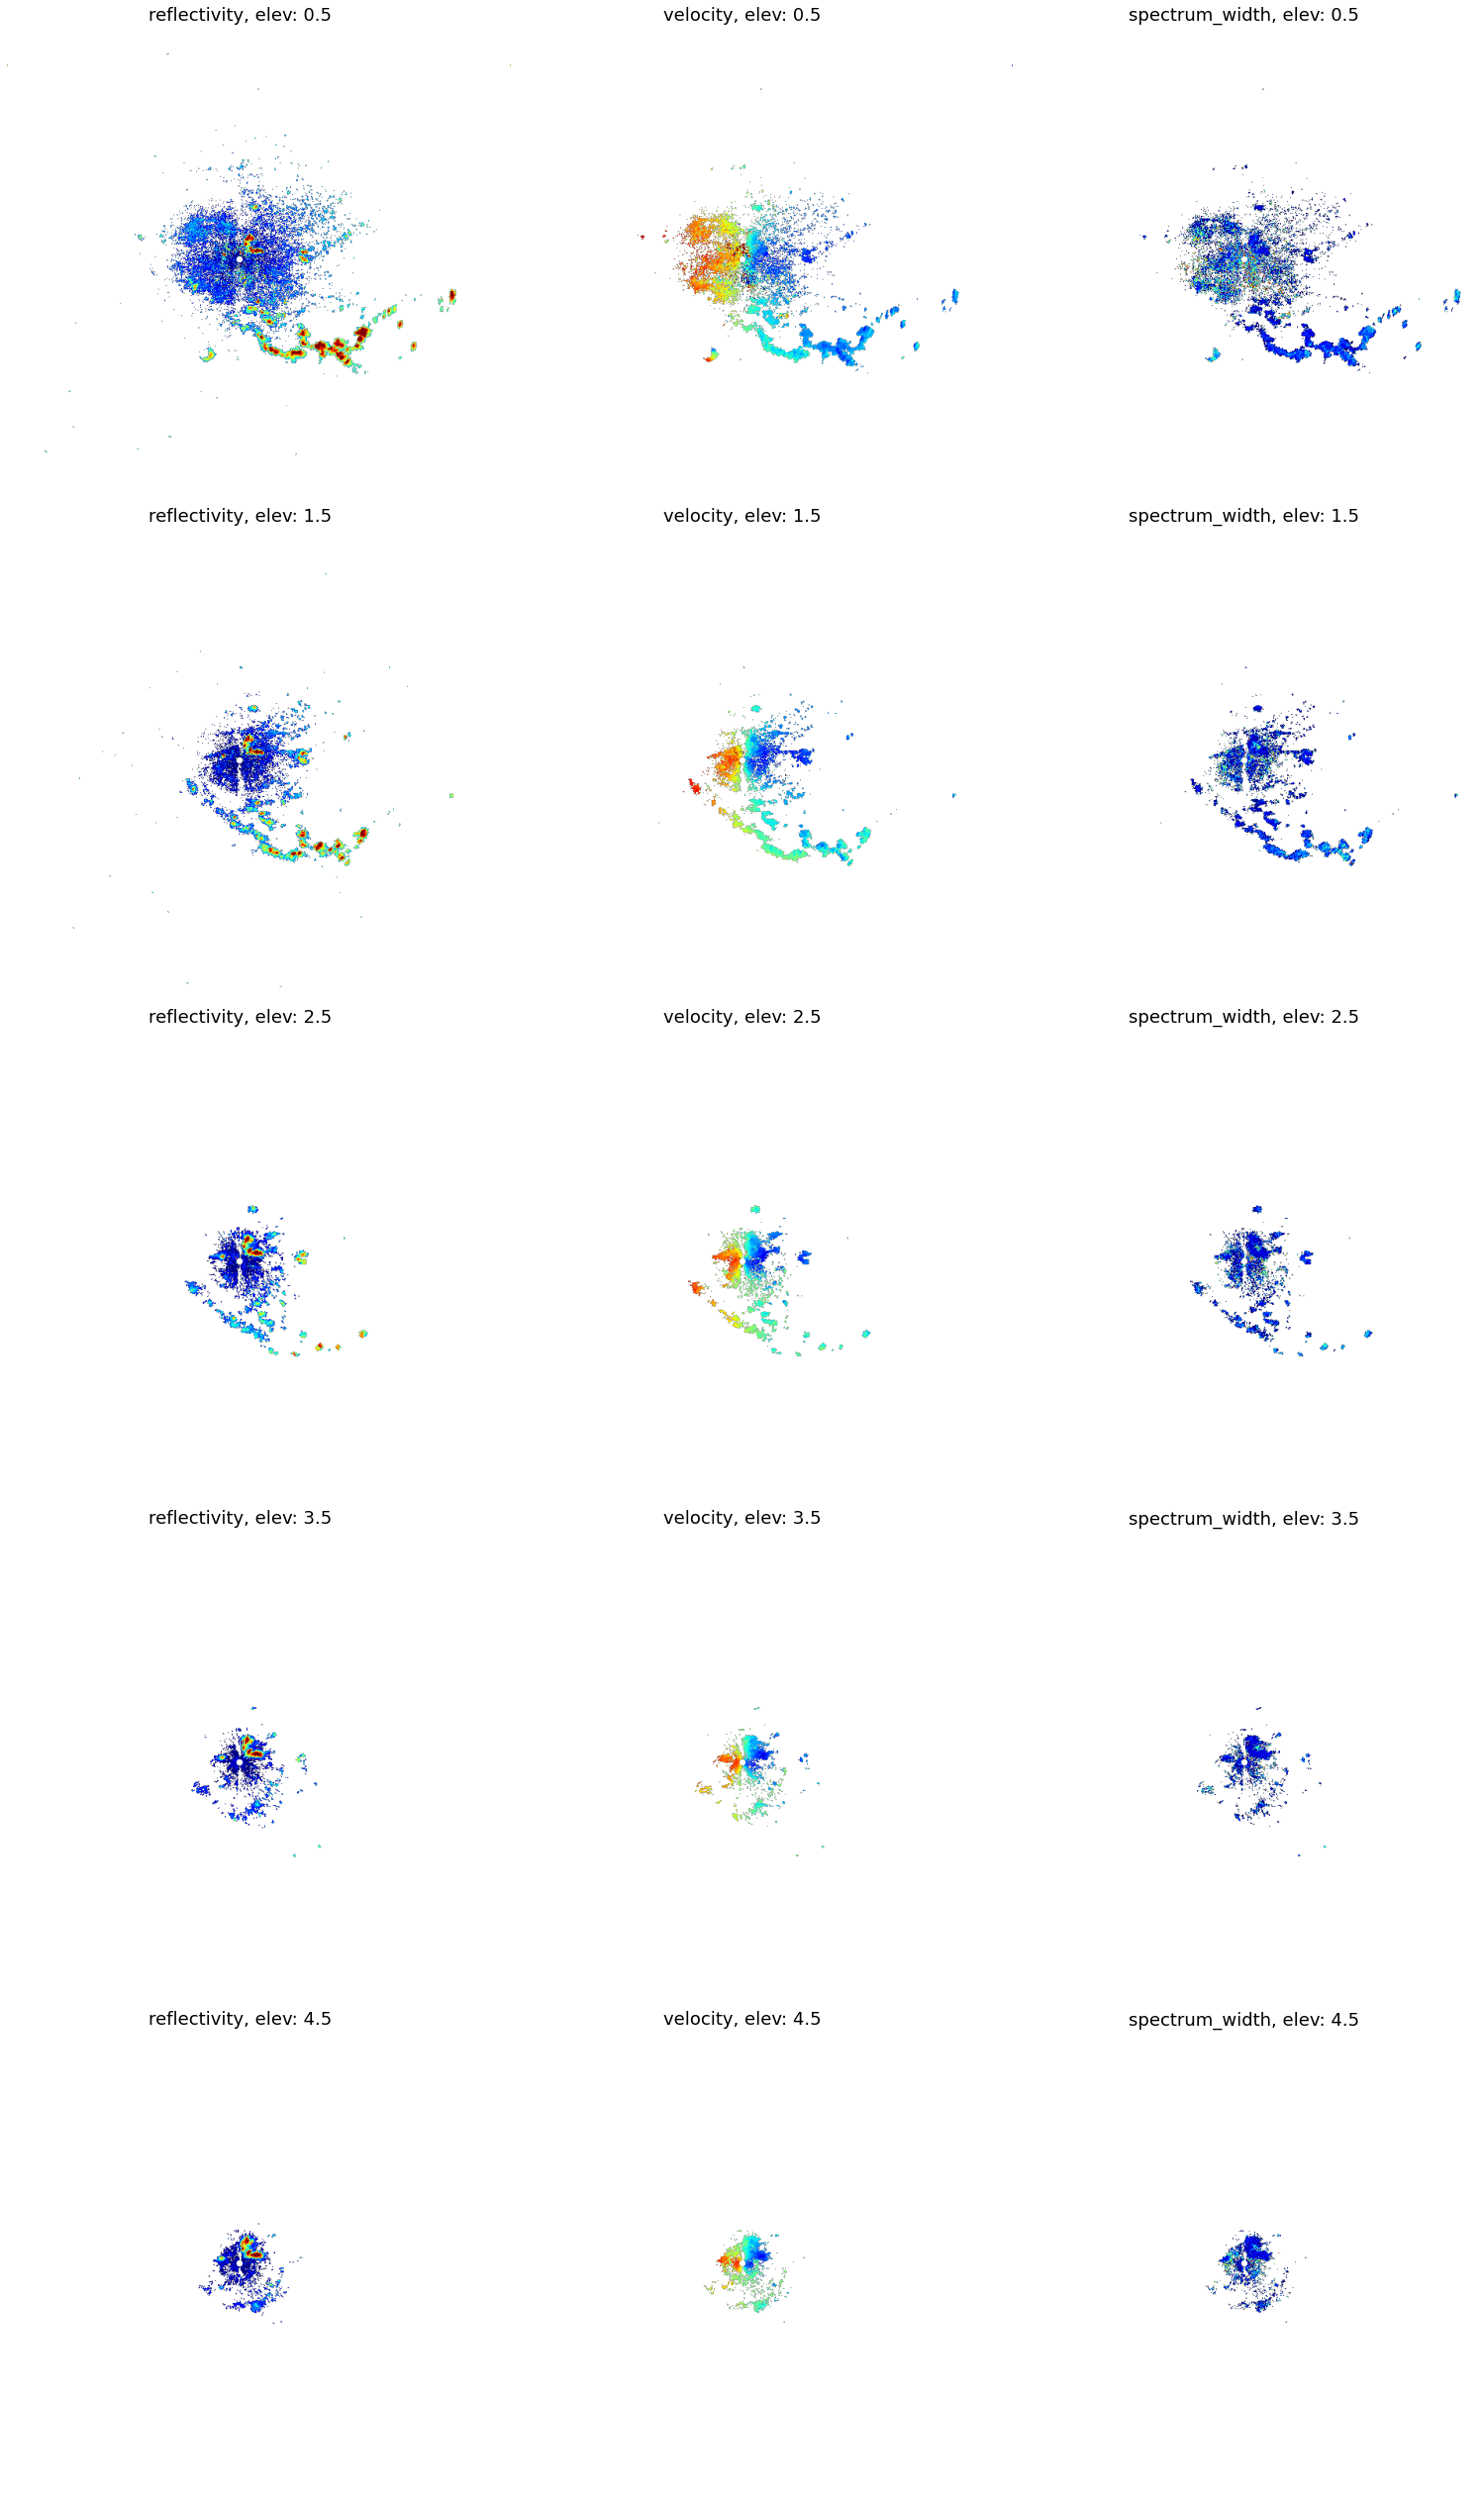

In [2]:
# Render and visualize a scan

SCAN = "KAMX20101024_111513_V03"
SCAN_FILE = f"/scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/{SCAN[4:8]}/{SCAN[8:10]}/{SCAN[10:12]}/{SCAN[:4]}/{SCAN}.gz"
    # /scratch2/wenlongzhao/roosts2021/libs/wsrdata/static/scans/scans/2010/10/22/KAMX/KAMX20101022_105646_V03.gz
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

radar = pyart.io.read_nexrad_archive(SCAN_FILE)
data, elevs, y, x = radar2mat(radar,
                              fields=ATTRIBUTES,
                              coords='cartesian',
                              r_max=150000,
                              dim=600,
                              elevs=ELEVATIONS)

fig, axs = plt.subplots(len(ELEVATIONS), len(ATTRIBUTES), figsize=(21,35), constrained_layout=True)
# fig.tight_layout()
for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        subplt = axs[j, i]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        rgb = cm(scale(data[attr][j, :, :], 
                       scale_clip[attr][0], 
                       scale_clip[attr][1]))
        subplt.imshow(rgb)

plt.show()

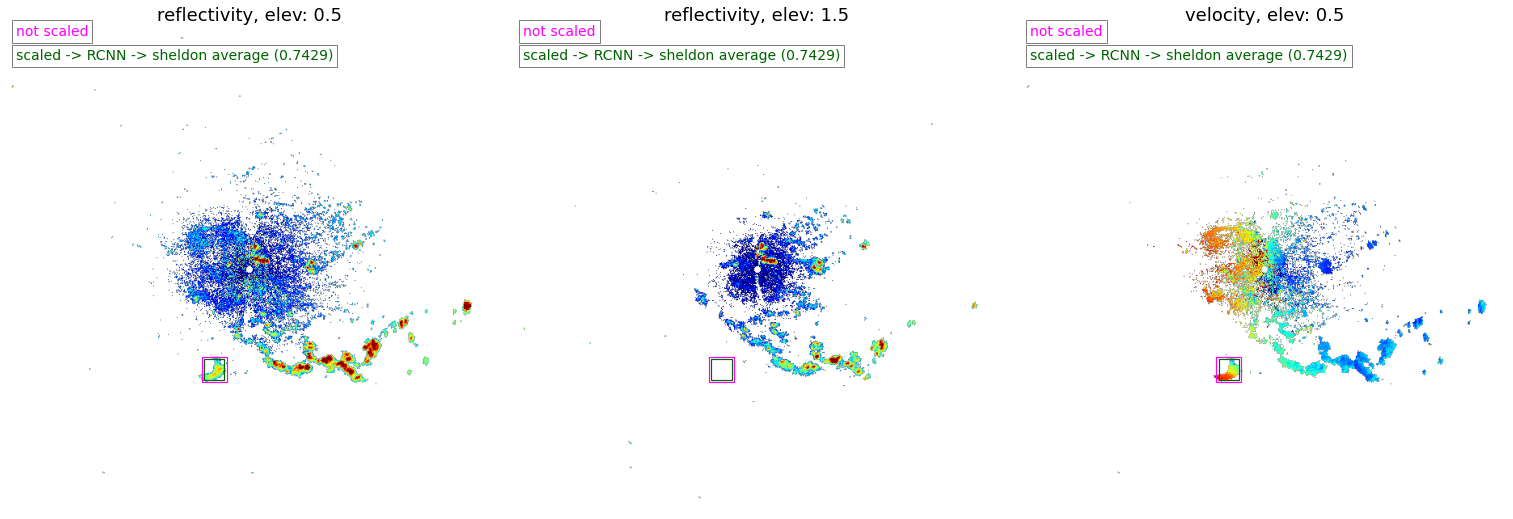

In [3]:
# Visualize an npy array with annotations from json

# define which scan to visualize, which json to be the source of annotations
SCAN = "KAMX20101024_112106_V03"
JSON_PATH = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts-v0.1.0-official/roosts-v0.1.0.json"
OUTPUT_DIR = "/scratch2/wenlongzhao/roosts2021/libs/wsrdata/datasets/roosts-v0.1.0-official/visualization"

# colors for bboxes
color_array = [
    '#FF00FF', # for not scaled boxes
    '#006400', # for scale strategy 1
    '#800080',
    '#FFA500',
    '#FFFF00'
]

# scale strategy 1: normalize to RCNN then to sheldon average
def scale_box_1(bbox, annotator_scale_factor):
    radius = [bbox[2]/2, bbox[3]/2]
    new_radius = [r/annotator_scale_factor*0.7429 for r in radius]
    center = [(2 * bbox[0] + bbox[2] - 1) / 2, (2 * bbox[1] + bbox[3] - 1) / 2]
    
    new_left = int(center[0] - new_radius[0])
    new_right = center[0] * 2 - new_left
    new_top = int(center[1] - new_radius[1])
    new_bottom = center[1] * 2 - new_top
    return [new_left, new_top, new_right - new_left + 1, new_bottom - new_top + 1]

with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
scan_to_id = {}
for split in dataset["scans"]:
    for scan in dataset["scans"][split]:
        scan_to_id[scan["scan"]] = scan["scan_id"]
scan = dataset["scans"]["train"][scan_to_id[SCAN]] # this scan is known to be annotated with a roost

array = np.load(scan["array_path"])
array_channel_indices = dataset["info"]["array_channel_indices"]

fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)
for i, (attr, elev) in enumerate([("reflectivity", "0.5"), ("reflectivity", "1.5"), ("velocity", "0.5")]):
    subplt = axs[i]
    subplt.axis('off')
    subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
    rgb = cm(scale(array[array_channel_indices[attr][elev], :, :], 
                   scale_clip[attr][0], 
                   scale_clip[attr][1]))
    subplt.imshow(rgb)
    for annotation in scan["annotations"]:
        bbox = annotation["bbox"]
        subplt.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                          fill=False,
                          edgecolor=color_array[0], 
                          linewidth=1.2)
        )
        subplt.text(10, 10, 'not scaled', 
                    bbox=dict(facecolor='white', alpha=0.5),fontsize=14, color=color_array[0])
        
        bbox = scale_box_1(bbox, dataset["info"]["bbox_scaling_factors"][annotation["bbox_annotator"]])
        subplt.add_patch(
            plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                          fill=False,
                          edgecolor=color_array[1], 
                          linewidth=1.2)
        )
        subplt.text(10, 40, 'scaled -> RCNN -> sheldon average (0.7429)', 
                    bbox=dict(facecolor='white', alpha=0.5),fontsize=14, color=color_array[1])

plt.show()


# if not os.path.exists(OUTPUT_DIR):
#     os.mkdir(OUTPUT_DIR)
# fig.savefig(os.path.join(OUTPUT_DIR, SCAN+".png"), facecolor="white")
# plt.close(fig)